In [1]:
from matplotlib import pyplot as plt
import numpy as np
import torch
from matplotlib.ticker import FormatStrFormatter

In [2]:
def gen_stencil(epsilon, wx, wy, h, ddtype="supg"):
    # print(epsilon, wx, wy, h)
    wlength = np.sqrt(wx**2+wy**2)
    pk = wlength*h/(2*epsilon)
    if ddtype == "supg" and pk > 1:
        delta = h/(2*wlength)*(1-1/pk)
    else:
        delta = 0

    wy = -wy
    stencil_diff = 1/3*np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])

    stencil_cvec = h/12*np.array([[-wx+wy,4*wy,wx+wy],[-4*wx,0,4*wx],[-(wx+wy),-4*wy,wx-wy]])

    w2 = wx**2+wy**2
    wxy = wx*wy
    stencil_supg = delta*np.array([[-1/6*w2+1/2*wxy,1/3*wx**2-2/3*wy**2,-1/6*w2-1/2*wxy],
                                    [-2/3*wx**2+1/3*wy**2,4/3*w2,-2/3*wx**2+1/3*wy**2],
                                    [-1/6*w2-1/2*wxy,1/3*wx**2-2/3*wy**2,-1/6*w2+1/2*wxy]])
    
    stencil = epsilon*stencil_diff + stencil_cvec + stencil_supg
    return stencil.reshape(1, 3, 3)

In [3]:
def ComputeSmootherFactor(KernelA, N, w):
    device = KernelA.device
    h = 1/N
    p1 = range(-N//2, N//2)
    p2 = range(-N//2, N//2)
    P1, P2 = np.meshgrid(p1, p2)
    P1 = torch.from_numpy(P1)
    P2 = torch.from_numpy(P2)
    P1, P2 = P1.to(device), P2.to(device)
    theta1 = 2j*np.pi*P1*h
    theta2 = 2j*np.pi*P2*h
    Y = torch.ones([KernelA.shape[0], 1, N, N], device=device)
    for i in range(KernelA.shape[0]):
        k1, k2, k3, k4, k5, k6, k7, k8, k9 = KernelA[i].flatten()[:]
        # taus = [w/KernelA[i, 0, 1, 1]]*10
        taus = [w]*10
        y = 1
        for j in range(len(taus)):
            y *= 1-taus[j] * (k1*torch.exp(-theta1)*torch.exp(-theta2)+k2*torch.exp(-theta2)+k3*torch.exp(theta1)*torch.exp(-theta2)+k4*torch.exp(-theta1)+k5+k6*torch.exp(theta1)+k7*torch.exp(-theta1)*torch.exp(theta2)+k8*torch.exp(theta2)+k9*torch.exp(theta1)*torch.exp(theta2))
        Y[i, 0, :, :] = y
    return Y

In [4]:
# wx = -np.sin(np.pi/6)
# wy = np.cos(np.pi/6) 
# epsilon = 1/200

wx = 1
wy = 0
epsilon = 1e-6
n = 128
h = 1/n
N = n+1
ddtype = "fem"
stencil = gen_stencil(epsilon, wx, wy, h, ddtype)
kernel = torch.from_numpy(stencil).unsqueeze(0)
w = 20
Y = ComputeSmootherFactor(kernel, N-1, w)

/var/folders/yk/45n_4n0s1s91zp87l61tkn_00000gn/T/ipykernel_7220/3651054658.py:20: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Copy.cpp:307.)
  Y[i, 0, :, :] = y


In [5]:
stencil

array([[[-6.51375000e-04, -3.33333333e-07,  6.50708333e-04],
        [-2.60450000e-03,  2.66666667e-06,  2.60383333e-03],
        [-6.51375000e-04, -3.33333333e-07,  6.50708333e-04]]])

1.0


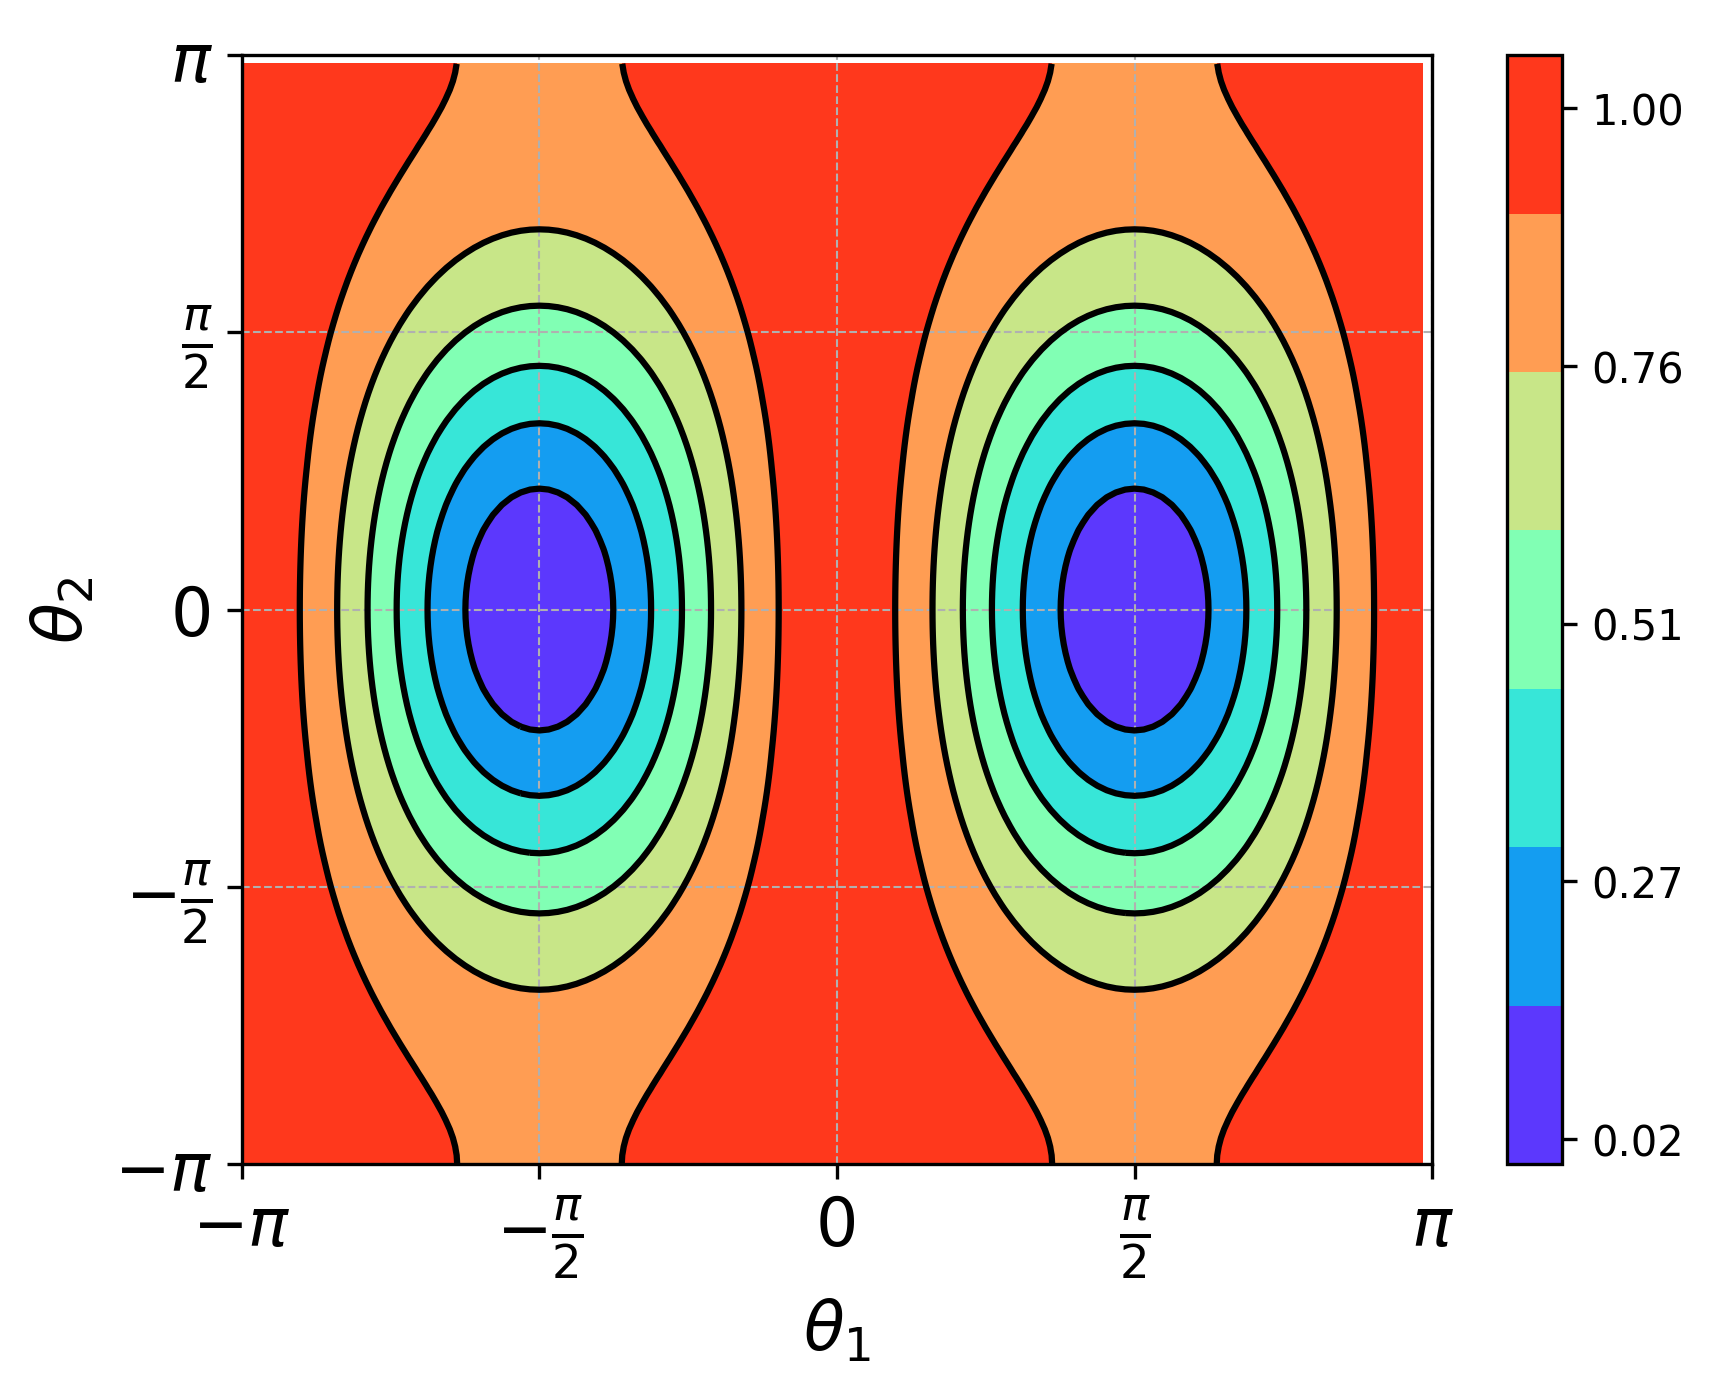

In [6]:
h = 1/n
p1 = range(-n//2, n//2)
p2 = range(-n//2, n//2)
P1, P2 = np.meshgrid(p1, p2)
theta1 = 2*np.pi*P1*h
theta2 = 2*np.pi*P2*h

Z = abs(Y[0, 0].cpu().detach().numpy())
print(Z.max())
plt.figure(dpi=300)
plt.contour(theta1, theta2, Z, colors='black')
contour = plt.contourf(theta1, theta2, Z, cmap='rainbow')
plt.colorbar(contour, ticks=np.linspace(Z.min(), Z.max(), num=5), format=FormatStrFormatter('%.2f'))

plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)

plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
            [r'$-\pi$', r'$-\frac{\pi}{2}$', '0', r'$\frac{\pi}{2}$', r'$\pi$'], fontsize=16)
plt.yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
            [r'$-\pi$', r'$-\frac{\pi}{2}$', '0', r'$\frac{\pi}{2}$', r'$\pi$'], fontsize=16)

plt.xlabel(r'$\theta_1$', fontsize=16)
plt.ylabel(r'$\theta_2$', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()